# Проанализируем возможность установления в аэропорту плитки для выработки пъезоэлектричества

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

<div class="alert alert-warning">
<b>Запишем взятые с Kaggle об аэропортах данные в переменную df</b></font>

In [2]:
df = pd.read_csv('C:/dataset_airport/archive/Airports2.csv', parse_dates=['Fly_date']) 
df['Fly_date'] = pd.to_datetime(df['Fly_date'])
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


<div class="alert alert-warning">
<b>Из всей таблицы возьмем только данные аэропорта ORD</b></font>

In [3]:
df_ord=df[(df.Origin_airport=='ORD')] 

In [4]:
df_ord.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
2066,ORD,EKO,"Chicago, IL","Elko, NV",177,238,2,1445,1992-05-01,16720340,38698,41.9786,-87.9048,40.824902,-115.792
2068,ORD,EKO,"Chicago, IL","Elko, NV",119,119,1,1445,1992-04-01,16720340,38698,41.9786,-87.9048,40.824902,-115.792
2071,ORD,EKO,"Chicago, IL","Elko, NV",215,238,2,1445,1992-06-01,16720340,38698,41.9786,-87.9048,40.824902,-115.792
2074,ORD,EKO,"Chicago, IL","Elko, NV",54,124,1,1445,1992-11-01,16720340,38698,41.9786,-87.9048,40.824902,-115.792
2076,ORD,EKO,"Chicago, IL","Elko, NV",61,119,1,1445,1992-07-01,16720340,38698,41.9786,-87.9048,40.824902,-115.792


<div class="alert alert-warning">
<b>Найдем период, в течение которого записывались данные об аэропорте и создадим отдельную таблицу, где будет храниться число человек в аэропорту для каждой отдельной даты</b></font>

In [5]:
df_ord.Fly_date.max()

Timestamp('2009-12-01 00:00:00')

In [6]:
df_ord.Fly_date.min()

Timestamp('1990-01-01 00:00:00')

In [7]:
df_date = df_ord.groupby(by=df_ord['Fly_date']).sum()

C:\Users\user\AppData\Local\Temp\ipykernel_16924\1288547408.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_date = df_ord.groupby(by=df_ord['Fly_date']).sum()


In [8]:
df_date.head()

,Passengers,Seats,Flights,Distance,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
Fly_date,,,,,,,,,,
1990-01-01,1586242,3405669,23616,470805,9935399088,2982272955,25439.031327,-53270.309055,23158.957318,-54547.716059
1990-02-01,1536908,2983349,20748,447580,9673078320,2949532728,24767.373735,-51863.832248,22582.909314,-52963.014055
1990-03-01,2017936,3472365,24132,440092,9312387264,2720323963,23843.844544,-49929.926639,21720.118836,-51251.215883
1990-04-01,1895031,3419758,23869,434224,9230412024,2626840931,23633.951547,-49490.402636,21557.819321,-50747.476167
1990-05-01,1981995,3568563,24740,428887,9377967456,2903416430,24011.758943,-50281.545840,22006.898932,-51344.423998


<div class="alert alert-warning">
<b>Построим прогноз пассажиропотока на следующий период, чтобы проследить тенденцию его роста или спада </b></font>

<div class="alert alert-warning">
<b>Разделим все данные на две выборки: обучающуюся и тестовую. Посмотрим на графике, как выглядит зависимость количества человек от даты для df_train </b></font>

In [9]:
df_train=df_date[(df_date.index<'2005')]

In [10]:
df_test=df_date[(df_date.index>='2005')]

In [11]:
df_train.head()

,Passengers,Seats,Flights,Distance,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
Fly_date,,,,,,,,,,
1990-01-01,1586242,3405669,23616,470805,9935399088,2982272955,25439.031327,-53270.309055,23158.957318,-54547.716059
1990-02-01,1536908,2983349,20748,447580,9673078320,2949532728,24767.373735,-51863.832248,22582.909314,-52963.014055
1990-03-01,2017936,3472365,24132,440092,9312387264,2720323963,23843.844544,-49929.926639,21720.118836,-51251.215883
1990-04-01,1895031,3419758,23869,434224,9230412024,2626840931,23633.951547,-49490.402636,21557.819321,-50747.476167
1990-05-01,1981995,3568563,24740,428887,9377967456,2903416430,24011.758943,-50281.545840,22006.898932,-51344.423998


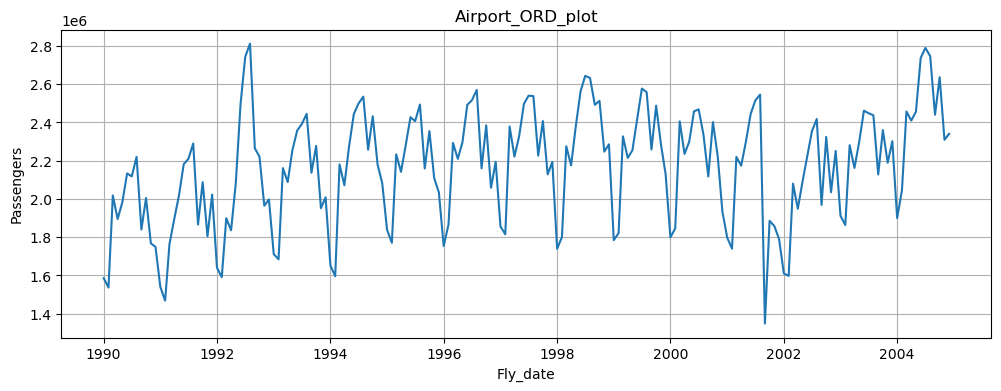

In [12]:
plt.plot(df_train.Passengers)
plt.title("Airport_ORD_plot")
plt.xlabel("Fly_date")
plt.ylabel("Passengers")
plt.gcf().set_size_inches(12, 4)
plt.grid()
plt.show()

<div class="alert alert-warning">
<b>Произведем декомпозицию временного ряда  </b></font>

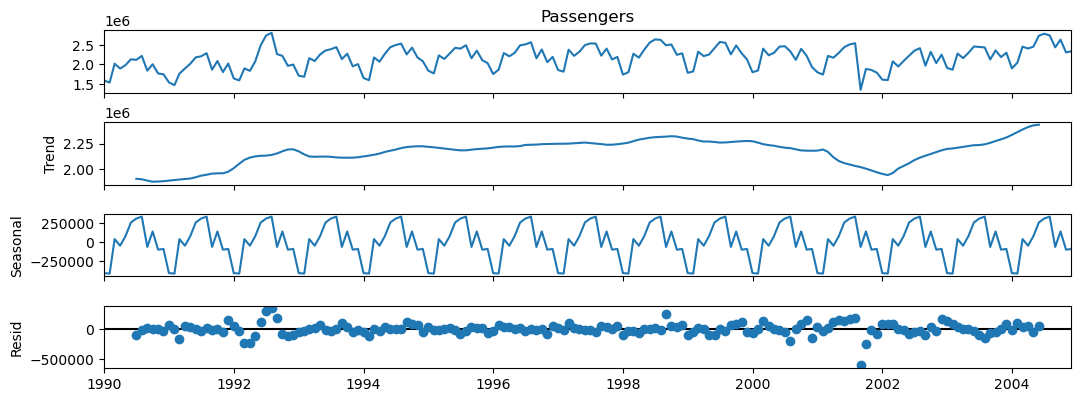

In [13]:
decomposition = seasonal_decompose(df_train.Passengers)
fig = decomposition.plot()
plt.gcf().set_size_inches(12, 4)
plt.show()

<div class="alert alert-warning">
<b>Реализуем модель SARIMA для прогнозирования будущих значений. Подгоним модель к данным </b></font>

In [14]:
best_model = SARIMAX(df_train['Passengers'], order=(2, 1, 2), seasonal_order=(2, 1, 2, 12)).fit(dis=-1)
print(best_model.summary())

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Anaconda\Lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  180
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -2203.708
Date:                            Sat, 09 Dec 2023   AIC                           4425.415
Time:                                    15:27:14   BIC                           4453.477
Sample:                                01-01-1990   HQIC                          4436.805
                                     - 12-01-2004                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1558      2.268      0.069      0.945      -4.288       4.600
ar.L2          0.4268      1.527   

<div class="alert alert-warning">
<b>Посмотрим, насколько хорошо подобраны параметры</b></font>

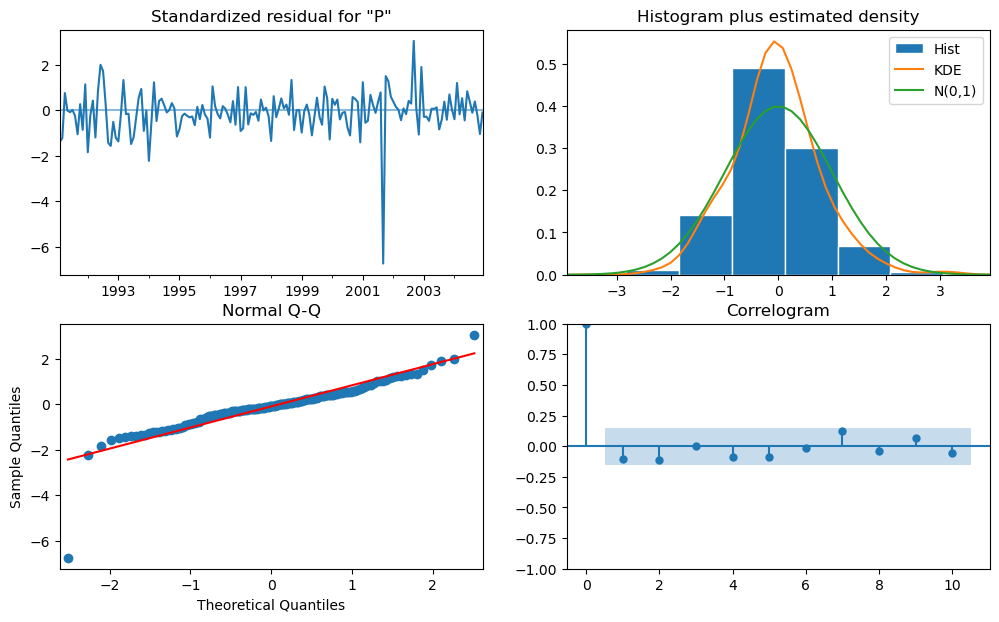

In [15]:
best_model.plot_diagnostics(figsize=(12,7));

<div class="alert alert-warning">
<b>Построим модельный прогноз</b></font>

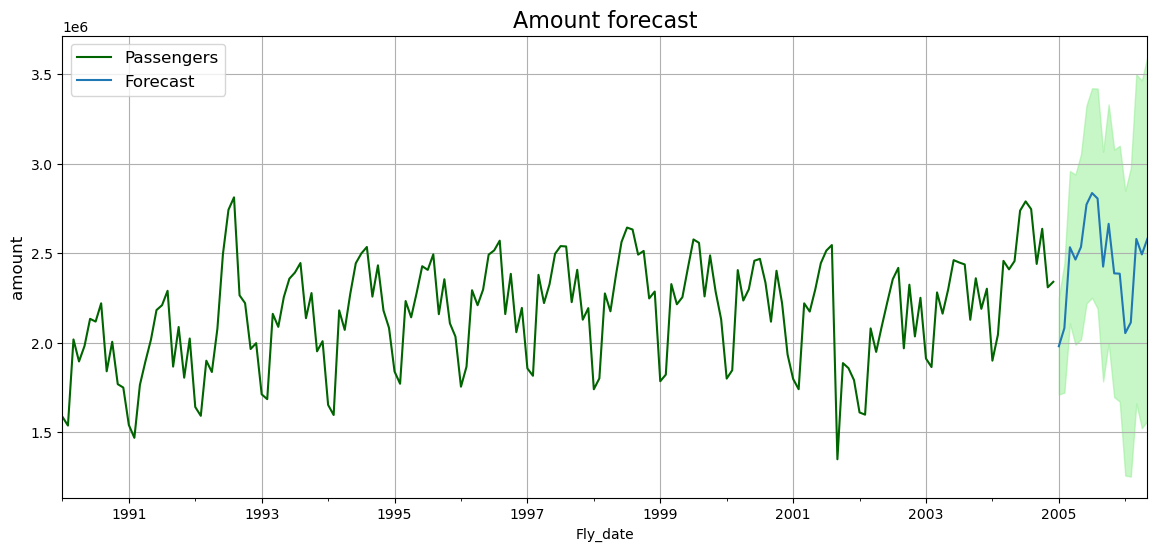

In [16]:
forecast_values = best_model.get_forecast(steps = 17)
forecast_ci = forecast_values.conf_int()

#Plot the data
ax = df_train.plot(y='Passengers', figsize = (14, 6), legend = True, color='darkgreen')

#Plot the forecasted values 
forecast_values.predicted_mean.plot(ax=ax, label='Forecast', figsize = (14, 6), grid=True)

#Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='lightgreen', alpha = .5)
plt.title('Amount forecast', size = 16)
plt.ylabel('amount', size=12)
plt.legend(loc='upper left', prop={'size': 12})
ax.axes.get_xaxis().set_visible(True)

<div class="alert alert-warning">
<b>Создадим два вектора: вектор предсказанных и вектор истинных значений</b></font>

In [17]:
df_test.Passengers[:'2006-05-01']

Fly_date
2005-01-01    2023042
2005-02-01    1990301
2005-03-01    2559838
2005-04-01    2399529
2005-05-01    2558576
2005-06-01    2732080
2005-07-01    2769436
2005-08-01    2669660
2005-09-01    2423335
2005-10-01    2567023
2005-11-01    2419195
2005-12-01    2380137
2006-01-01    2164873
2006-02-01    2102340
2006-03-01    2594416
2006-04-01    2434137
2006-05-01    2575031
Name: Passengers, dtype: int64

In [18]:
forecast_values.predicted_mean

2005-01-01    1.979966e+06
2005-02-01    2.081325e+06
2005-03-01    2.533079e+06
2005-04-01    2.464161e+06
2005-05-01    2.534599e+06
2005-06-01    2.771842e+06
2005-07-01    2.835817e+06
2005-08-01    2.805148e+06
2005-09-01    2.424939e+06
2005-10-01    2.663861e+06
2005-11-01    2.387180e+06
2005-12-01    2.385378e+06
2006-01-01    2.053385e+06
2006-02-01    2.112968e+06
2006-03-01    2.579593e+06
2006-04-01    2.492938e+06
2006-05-01    2.580525e+06
Freq: MS, Name: predicted_mean, dtype: float64

<div class="alert alert-warning">
<b>Найдем среднеквадратичную ошибку и извлечем корень</b></font>

In [19]:
mean_squared_error(forecast_values.predicted_mean, df_test.Passengers[:'2006-05-01'], squared=False)

62608.2024959022

<div class="alert alert-warning">
<b>Найдем значение средней абсолютной погрешности в процентах</b></font>

In [20]:
mean_absolute_percentage_error(forecast_values.predicted_mean, df_test.Passengers[:'2006-05-01'])

0.020070867962971518

<div class="alert alert-warning">
<b>Погрешность получилась 2%. Протестируем нашу модель на всем объеме данных</b></font>

In [21]:
df_date.head()

,Passengers,Seats,Flights,Distance,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
Fly_date,,,,,,,,,,
1990-01-01,1586242,3405669,23616,470805,9935399088,2982272955,25439.031327,-53270.309055,23158.957318,-54547.716059
1990-02-01,1536908,2983349,20748,447580,9673078320,2949532728,24767.373735,-51863.832248,22582.909314,-52963.014055
1990-03-01,2017936,3472365,24132,440092,9312387264,2720323963,23843.844544,-49929.926639,21720.118836,-51251.215883
1990-04-01,1895031,3419758,23869,434224,9230412024,2626840931,23633.951547,-49490.402636,21557.819321,-50747.476167
1990-05-01,1981995,3568563,24740,428887,9377967456,2903416430,24011.758943,-50281.545840,22006.898932,-51344.423998


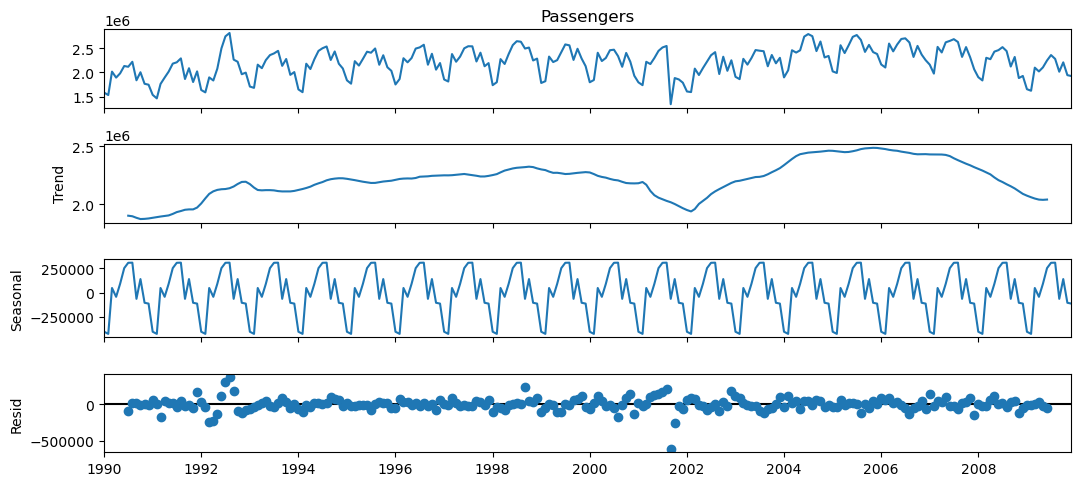

In [22]:
decomposition = seasonal_decompose(df_date.Passengers)
fig = decomposition.plot()
plt.gcf().set_size_inches(12, 5)
plt.show()

<div class="alert alert-warning">
<b>Реализуем модель SARIMA для прогнозирования будущих значений. Подгоним модель к данным, подобрав параметры</b></font>

In [23]:
best_model = SARIMAX(df_date['Passengers'], order=(2, 1, 2), seasonal_order=(2, 1, 2, 12)).fit(dis=-1)
print(best_model.summary())

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Anaconda\Lib\site-packages\statsmodels\base\optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  240
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -2973.121
Date:                            Sat, 09 Dec 2023   AIC                           5964.243
Time:                                    15:27:22   BIC                           5995.067
Sample:                                01-01-1990   HQIC                          5976.681
                                     - 12-01-2009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0804      1.995      0.541      0.588      -2.831       4.991
ar.L2         -0.2205      1.345   

D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


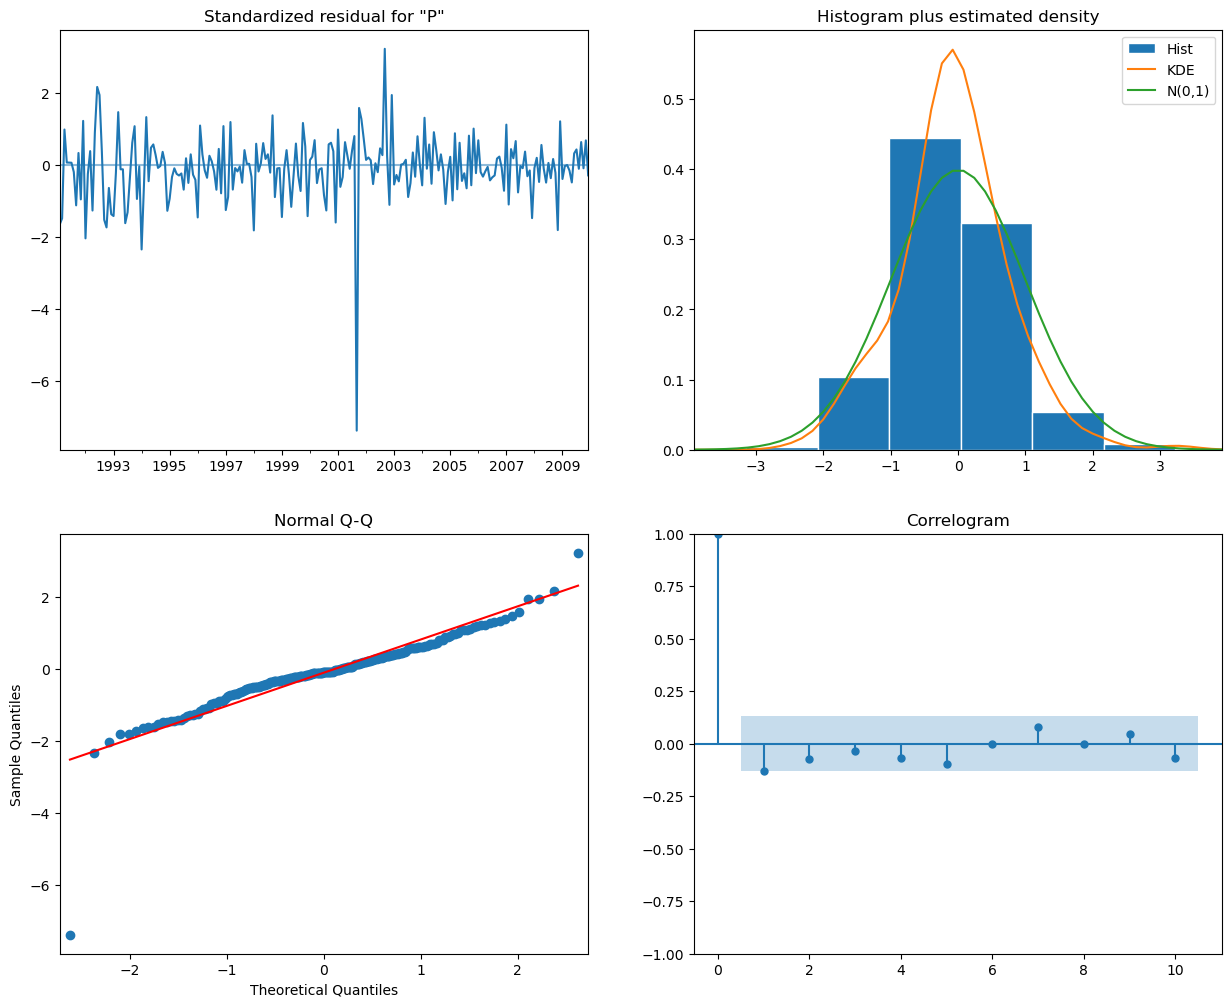

In [24]:
best_model.plot_diagnostics(figsize=(15,12) );

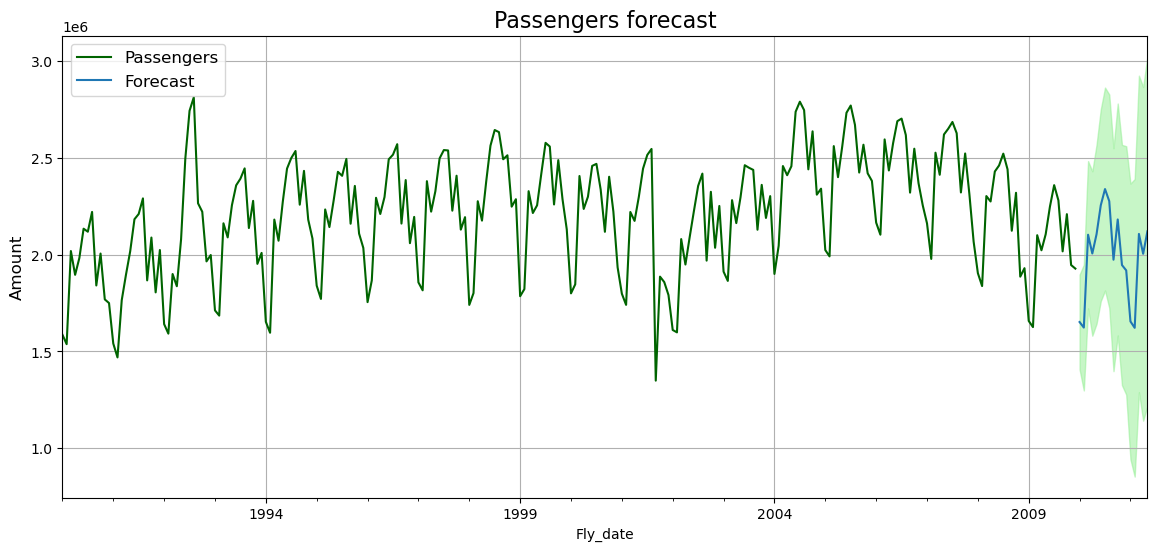

In [25]:
forecast_values = best_model.get_forecast(steps = 17)
forecast_ci = forecast_values.conf_int()

#Plot the data
ax = df_date.plot(y='Passengers', figsize = (14, 6), legend = True, color='darkgreen')

#Plot the forecasted values 
forecast_values.predicted_mean.plot(ax=ax, label='Forecast', figsize = (14, 6), grid=True)

#Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='lightgreen', alpha = .5)
plt.title('Passengers forecast', size = 16)
plt.ylabel('Amount', size=12)
plt.legend(loc='upper left', prop={'size': 12})
ax.axes.get_xaxis().set_visible(True)

<div class="alert alert-warning">
<b>Создадим вектор предсказанных значений</b></font>

In [26]:
forecast_values.predicted_mean

2010-01-01    1.651246e+06
2010-02-01    1.622568e+06
2010-03-01    2.102182e+06
2010-04-01    2.005249e+06
2010-05-01    2.104688e+06
2010-06-01    2.254343e+06
2010-07-01    2.338037e+06
2010-08-01    2.275456e+06
2010-09-01    1.973078e+06
2010-10-01    2.180994e+06
2010-11-01    1.945532e+06
2010-12-01    1.917973e+06
2011-01-01    1.654414e+06
2011-02-01    1.621307e+06
2011-03-01    2.106306e+06
2011-04-01    2.003669e+06
2011-05-01    2.119741e+06
Freq: MS, Name: predicted_mean, dtype: float64

<div class="alert alert-warning">
<b>Так как тенденции к спаду пассажиропотока не наблюдается, можно продолжать исследование, не беря во внимание на то, что данные не новые</b></font>

<div class="alert alert-warning">
<b>Посчитаем, какое количество самолетов улетает и прилетает в этот аэропорт каждый день. В зависимости от этого построим роаспределение пассажиропотока</b></font>

In [27]:
df_ord
df_ord.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
2066,ORD,EKO,"Chicago, IL","Elko, NV",177,238,2,1445,1992-05-01,16720340,38698,41.9786,-87.9048,40.824902,-115.792
2068,ORD,EKO,"Chicago, IL","Elko, NV",119,119,1,1445,1992-04-01,16720340,38698,41.9786,-87.9048,40.824902,-115.792
2071,ORD,EKO,"Chicago, IL","Elko, NV",215,238,2,1445,1992-06-01,16720340,38698,41.9786,-87.9048,40.824902,-115.792
2074,ORD,EKO,"Chicago, IL","Elko, NV",54,124,1,1445,1992-11-01,16720340,38698,41.9786,-87.9048,40.824902,-115.792
2076,ORD,EKO,"Chicago, IL","Elko, NV",61,119,1,1445,1992-07-01,16720340,38698,41.9786,-87.9048,40.824902,-115.792


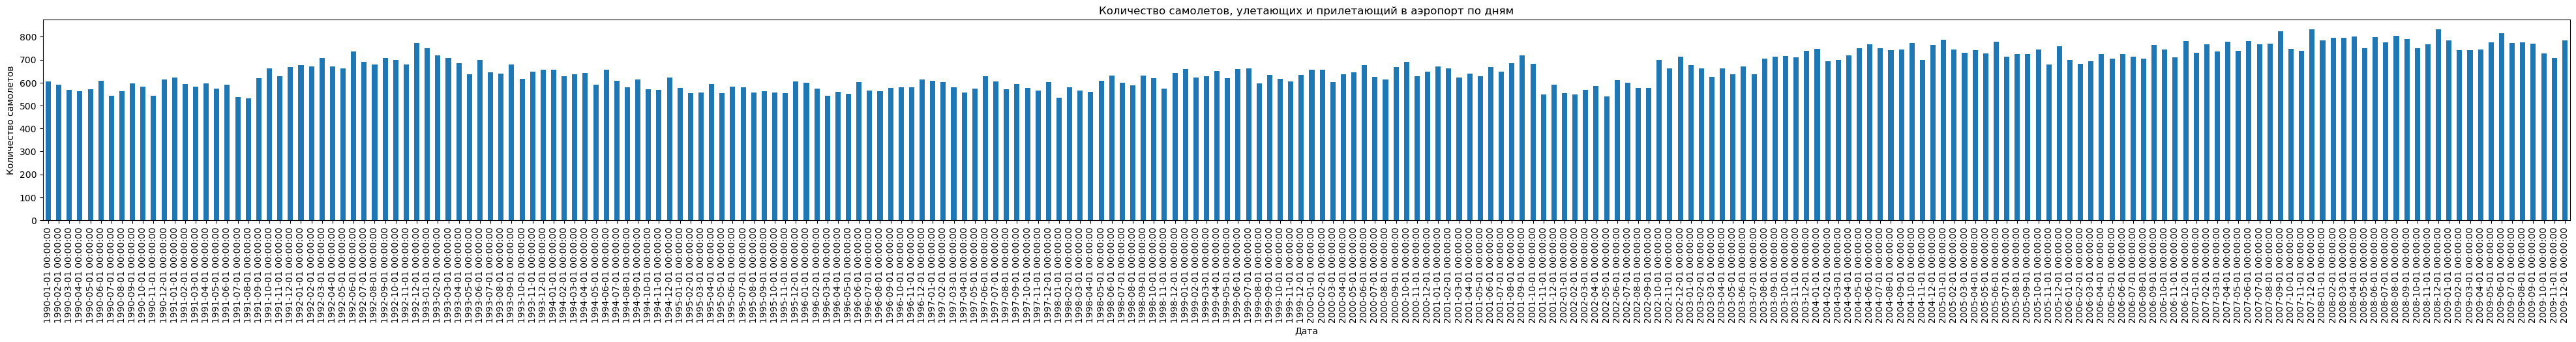

In [28]:
date_counts = df_ord['Fly_date'].value_counts().sort_index()

# Построение графика
date_counts.plot(kind='bar')
plt.xlabel('Дата')
plt.ylabel('Количество самолетов')
plt.title('Количество самолетов, улетающих и прилетающий в аэропорт по дням')
plt.gcf().set_size_inches(50, 4)
plt.show()

In [29]:
average_flights_per_day = df_ord.groupby(df_ord['Fly_date'].dt.date)['Fly_date'].count().mean()
print("Среднее количество вылетов в день: ", average_flights_per_day)

Среднее количество вылетов в день:  660.4


<div class="alert alert-warning">
<b>Лучше ориентироваться на минимальное значение. Посчитаем его</b></font>

In [30]:
min_flights_per_day = df_ord.groupby(df_ord['Fly_date'].dt.date)['Fly_date'].count().min()
print("Минимальное количество вылетов в день: ", min_flights_per_day)

Минимальное количество вылетов в день:  531


<div class="alert alert-warning">
<b>Посчитаем средний и минимальный пассажиропоток в день</b></font>

In [31]:
average_flights_pass = df_date['Passengers'].mean()
print("Средний пассажиропоток в день: ", average_flights_pass)

Средний пассажиропоток в день:  2204242.125


In [32]:
min_flights_pass = df_date['Passengers'].min()
print("Минимальный пассажиропоток в день: ", min_flights_pass)

Минимальный пассажиропоток в день:  1348607


In [33]:
!pip install xlrd


<div class="alert alert-warning">
<b>Посчитаем, во сколько раз площадь аэропорта ORD (международного аэропорта О'Хара) больше площади аэропорта Пулково</b></font>

In [34]:
s_pulkovo = 13.5

In [35]:
s_use = 30.87

In [36]:
#s_use = float(input("Введите площадь объекта(в км^2): "))

In [37]:
k = s_use/s_pulkovo
print("Коэффициент k: ", k)

Коэффициент k:  2.2866666666666666


<div class="alert alert-warning">
<b>Выгрузим данные о потреблении электроэнергии. Имеются, к сожалению, лишь данные из Пулково. Поэтому возьмем просто максимальное значение и воспользуемся найденным ранее коэффициентом</b></font>

In [38]:
df_vatt = pd.read_excel('C:/Users/user/Downloads/august.xls',  sheet_name='Лист2')

# Вывод данных
print(df_vatt[1:10])

     Месяц  Объем полезного отпуска электроэнергии, МВтч  \
1  Февраль                                       567.096   
2     Март                                       442.880   
3   Апрель                                       438.174   
4      Май                                       379.516   
5     Июнь                                       289.590   
6     Июль                                       242.018   
7   Август                                       289.698   

   Объем полезного отпуска электрической мощности, МВт  
1                                              1.681    
2                                              1.313    
3                                              1.229    
4                                              0.690    
5                                              0.527    
6                                              0.440    
7                                              0.527    


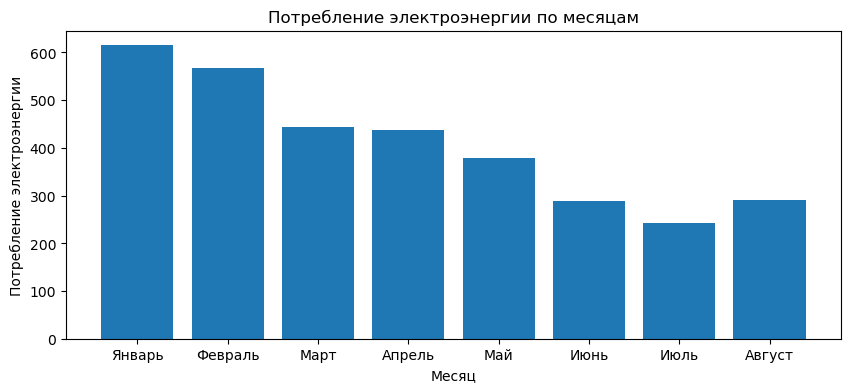

In [39]:
x = df_vatt['Месяц']
y = df_vatt.iloc[:, 1]

plt.bar(x, y)

plt.xlabel('Месяц')
plt.ylabel('Потребление электроэнергии')
plt.title('Потребление электроэнергии по месяцам')
plt.gcf().set_size_inches(10, 4)

plt.show()

<div class="alert alert-warning">
<b>Умножим значения на найденный коэффициент</b></font>

In [40]:
df_vatt.iloc[:, 1] = df_vatt.iloc[:, 1] * k

<div class="alert alert-warning">
<b>Отобразим на графике эти данные, учитывая этот коэффициент</b></font>

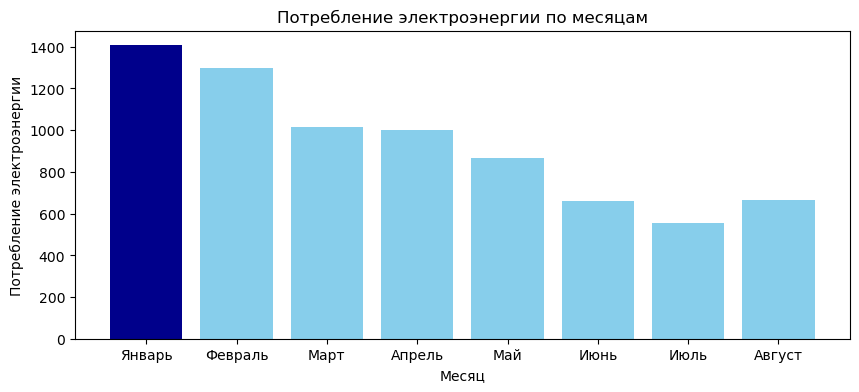

In [41]:
x = df_vatt['Месяц']
y = df_vatt.iloc[:, 1]

# Находим индекс столбца с максимальным значением
max_index = y.idxmax()

# Создаем список цветов для столбцов, где самый высокий столбик будет отличаться
colors = ['skyblue'] * len(x)  # Все столбцы инициализируются цветом skyblue
colors[max_index] = 'darkblue'     # Меняем цвет самого высокого столбика на red

# Создаем график столбцов с указанием цветов
plt.bar(x, y, color=colors)

# Добавляем подписи осей и заголовок
plt.xlabel('Месяц')
plt.ylabel('Потребление электроэнергии')
plt.title('Потребление электроэнергии по месяцам')
plt.gcf().set_size_inches(10, 4)
# Показываем график
plt.show()

<div class="alert alert-warning">
<b>Максимальное значение соответствует январю. Будем ориентироваться на него </b></font>

In [42]:
max_value = df_vatt.iloc[:, 1].max()
print("Наибольшее значение потреблиемой электроэнергии в месяц: ", max_value, "Мвт")

Наибольшее значение потреблиемой электроэнергии в месяц:  1405.72376 Мвт


<div class="alert alert-warning">
<b>Одно нажатие на плитку дает 5 вт. 
Посмотрим, сколько можно получить электроэнергии в месяц от ста плиток. Будем считать, что человек наступает на 10% плиток.</b></font>

In [43]:
number_of_tiles = 100;
percent = 0.1;
air_vatt_per_day = (5*min_flights_pass*number_of_tiles*30*percent)/1000000
print("Вырабатываемая энергия в месяц: ", air_vatt_per_day, "Мвт")

Вырабатываемая энергия в месяц:  2022.9105 Мвт


In [44]:
mean_value = df_vatt.iloc[:, 1].mean()
print(mean_value)

932.8799666666666


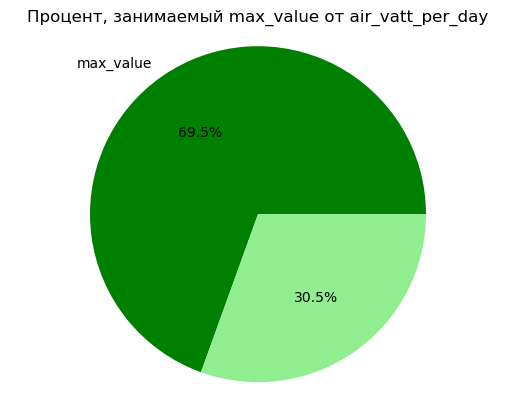

In [45]:
# Рассчитываем процент, который занимает max_value от air_vatt_per_day
percentage = (max_value / air_vatt_per_day) * 100

# Создаем список значений для круговой диаграммы
sizes = [percentage, 100 - percentage]

# Задаем названия секторов
labels = ['max_value','']

# Задаем цвета секторов
colors = ['green','lightgreen']

# Создаем круговую диаграмму
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')

# Отображаем круговую диаграмму
plt.axis('equal')
plt.title('Процент, занимаемый max_value от air_vatt_per_day')

# Отображаем диаграмму
plt.show()

<div class="alert alert-warning">
<b>Десяти плиток будет много. Рассчитаем оптимальное количество.</b></font>

In [46]:
found_number_of_tiles = 100
for number_of_tiles in range(1, 101):
    air_vatt_per_day = (5 * min_flights_pass * number_of_tiles*percent * 30) / 1000000
    if (air_vatt_per_day >= (110 / 100) * max_value):
        found_number_of_tiles = number_of_tiles
        break
    
print("Найдено значение number_of_tiles:", found_number_of_tiles)

Найдено значение number_of_tiles: 77


<div class="alert alert-warning">
<b>Пересчитаем количество электроэнергии в месяц</b></font>

In [47]:
air_vatt_per_day_best = (5*min_flights_pass*found_number_of_tiles*percent*30)/1000000
print("Вырабатываемая энергия в месяц: ", air_vatt_per_day_best, "Мвт")

Вырабатываемая энергия в месяц:  1557.641085 Мвт


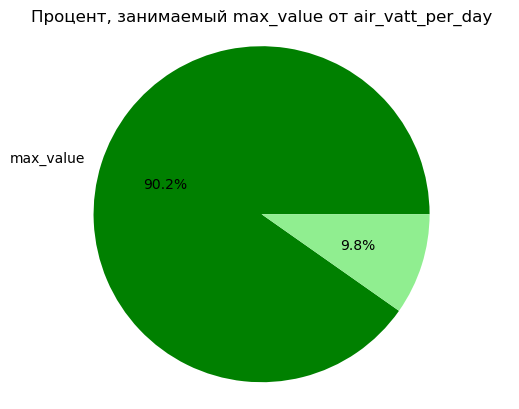

In [48]:
percentage = (max_value / air_vatt_per_day_best) * 100

sizes = [percentage, 100 - percentage]

labels = ['max_value','']

colors = ['green','lightgreen']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')

plt.axis('equal')
plt.title('Процент, занимаемый max_value от air_vatt_per_day')

plt.show()

<div class="alert alert-warning">
<b>Выработанной таким образом электроэнергии с запасом хватит на аэропорт.</b></font>

<div class="alert alert-warning">
<b>Осталось рассчитать, имеет ли установка такой плитки некую денежную выгоду</b></font>

<div class="alert alert-warning">
<b>Цена за одну плитку 70$. А рассчитана она на 20 млн нажатий.
Посмотрим, как часто ее придется менять.</b></font>

In [49]:
max_value_guarantee = 20000000
#print(min_flights_pass)
price_per_one = 7000
frequency_reset = (max_value_guarantee/(min_flights_pass*percent))
print ("Менять плитку надо раз в ",frequency_reset,"дней. Или, что то же самое,", 360/frequency_reset,"раза в год." )

Менять плитку надо раз в  148.30117298812775 дней. Или, что то же самое, 2.4274926 раза в год.


<div class="alert alert-warning">
<b>Выходит, что за год платить за плитку аэропорту придется:</b></font>

In [50]:
prise_with_tiles = price_per_one*found_number_of_tiles*360/frequency_reset
print("Оплата с плиткой за год:",prise_with_tiles,"тыс руб")

Оплата с плиткой за год: 1308418.5114 тыс руб


<div class="alert alert-warning">
<b>Учитывая расходы среднего аэропорта на энергию и средний тариф, приходим к выводу о целесообразности данного нововведения.</b></font>

In [51]:
price_kvatt_per_hour=5.7
price_kvatt_per_hour = price_kvatt_per_hour*0.001

In [52]:
price_without_tiles = price_kvatt_per_hour*24*365*mean_value*12*1.5*k
print("Оплата без использования плиток за год:",price_without_tiles,"тыс руб")

Оплата без использования плиток за год: 1917255.952318896 тыс руб


In [53]:
delta = price_without_tiles-prise_with_tiles
print("Выигрыш в цене составляет:",delta,"тыс руб")

Выигрыш в цене составляет: 608837.4409188961 тыс руб


<div class="alert alert-warning">
<b>Таким образом, установка пьезоплиток в аэропорту О'Хара выгодна</b></font>